# **FORECASTING**

**Forecasting** adalah memprediksi atau meramalkan kejadian di masa depan dengan menggunakan data pada masa sebelumnya sebagai pertimbangan

## Data Understanding

### Area yang digunakan

Saya mengambil data NO2 di sebagian besar Kabupaten Gresik dan Sekitarnya

image.png

### NO2 Data Collection
Mengumpulkan data dan dijadikan format CSV.

In [ ]:
pip install xarray pandas openeo



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
import openeo
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:


# 1. Koneksi ke Copernicus Data Space
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

# 2. AOI: poligon kedua dari data kamu 
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
                        [
              112.457276386427,
              -6.871540659610858
            ],
            [
              112.457276386427,
              -7.232534927888068
            ],
            [
              112.67620590724198,
              -7.232534927888068
            ],
            [
              112.67620590724198,
              -6.871540659610858
            ],
            [
              112.457276386427,
              -6.871540659610858
            ]
        ]
    ],
}

# 3. Ambil data Sentinel-5P (band "NO2")
s5p = connection.load_collection(
    "SENTINEL_5P_L2",
    spatial_extent={
        "west": 112.457276386427,
        "south": -7.232534927888068,
        "east": 112.67620590724198,
        "north": -6.871540659610858,
    },
    temporal_extent=["2025-09-23", "2025-10-22"],
    bands=["NO2"],
)

# 4. Mask nilai negatif (data invalid)
def mask_invalid(x):
    return x < 0

s5p_masked = s5p.mask(s5p.apply(mask_invalid))

# 5. Agregasi temporal harian
daily_mean = s5p_masked.aggregate_temporal_period(period="day", reducer="mean")

# 6. Agregasi spasial (rata-rata dalam AOI)
daily_mean_aoi = daily_mean.aggregate_spatial(geometries=aoi, reducer="mean")

# 7. Jalankan batch job dan hasilkan file CSV
job = daily_mean_aoi.execute_batch(out_format="CSV")

# 8. Unduh hasil job
results = job.get_results()
results.download_files("no2_results")

# 9. Baca file CSV hasil
import os
for f in os.listdir("no2_results"):
    if f.endswith(".csv"):
        df = pd.read_csv(os.path.join("no2_results", f))
        print("File ditemukan:", f)
        break

# 10. Pastikan kolom tanggal benar
df["date"] = pd.to_datetime(df["date"])

# 11. Buat kolom bulan (YYYY-MM)
df["month"] = df["date"].dt.to_period("M")

# 12. Hitung rata-rata NO2 per bulan
df_monthly = df.groupby("month", as_index=False)["NO2"].mean()


Authenticated using refresh token.
0:00:00 Job 'j-251024150251442c872f3744a557a060': send 'start'


0:00:14 Job 'j-251024150251442c872f3744a557a060': created (progress 0%)
0:00:23 Job 'j-251024150251442c872f3744a557a060': created (progress 0%)
0:00:30 Job 'j-251024150251442c872f3744a557a060': created (progress 0%)
0:00:40 Job 'j-251024150251442c872f3744a557a060': created (progress 0%)
0:00:50 Job 'j-251024150251442c872f3744a557a060': running (progress N/A)
0:01:02 Job 'j-251024150251442c872f3744a557a060': running (progress N/A)
0:01:18 Job 'j-251024150251442c872f3744a557a060': running (progress N/A)
0:01:40 Job 'j-251024150251442c872f3744a557a060': running (progress N/A)
0:02:05 Job 'j-251024150251442c872f3744a557a060': running (progress N/A)
0:02:36 Job 'j-251024150251442c872f3744a557a060': finished (progress 100%)
File ditemukan: timeseries.csv


/tmp/ipykernel_15189/2731399100.py:81: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["date"].dt.to_period("M")


### Baca Dataset

In [75]:
new_df = pd.read_csv('no2_results/timeseries.csv')
new_df = new_df.sort_values(by='date').reset_index(drop=True)
new_df['date'] = pd.to_datetime(new_df['date']).dt.date
new_df

Unnamed: 0        date       NO2
0            0  2025-09-22  0.000112
1            1  2025-09-23  0.000112
2            2  2025-09-24  0.000202
3            3  2025-09-25  0.000073
4            4  2025-09-26  0.000043
5            5  2025-09-27  0.000034
6            6  2025-09-28  0.000026
7            7  2025-09-29  0.000038
8            8  2025-09-30  0.000047
9            9  2025-10-01  0.000056
10          10  2025-10-02  0.000066
11          11  2025-10-03  0.000040
12          12  2025-10-04  0.000070
13          13  2025-10-05  0.000039
14          14  2025-10-06  0.000051
15          15  2025-10-07  0.000081
16          16  2025-10-08  0.000063
17          17  2025-10-09  0.000119
18          18  2025-10-10  0.000096
19          19  2025-10-11  0.000053
20          20  2025-10-12  0.000022
21          21  2025-10-13  0.000011
22          22  2025-10-14  0.000041
23          23  2025-10-15  0.000033
24          24  2025-10-16  0.000051
25          25  2025-10-17  0.000050
26          26  2025-10-18  0.000040
27          27  2025-10-19  0.000034
28          28  2025-10-20  0.000045
29          29  2025-10-21  0.000056

### Deteksi Missing Value

In [52]:
missing_count = new_df.isnull().sum()
missing_percent = (missing_count / len(new_df)) * 100

missing_table = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percent (%)': missing_percent.round(2)
})

missing_table

Missing Count  Missing Percent (%)
Unnamed: 0              0                  0.0
date                    0                  0.0
NO2                     0                  0.0

### Visualisasi NO2

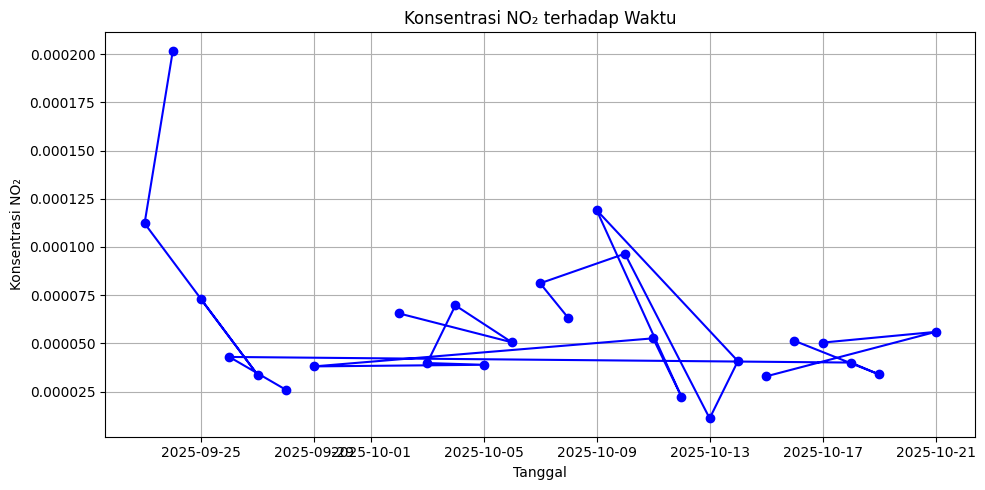

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['NO2'], marker='o', linestyle='-', color='blue')
plt.title("Konsentrasi NO₂ terhadap Waktu")
plt.xlabel("Tanggal")
plt.ylabel("Konsentrasi NO₂")
plt.grid(True)
plt.tight_layout()
plt.show()

## Data Preprocessing

### Tangani Missing Value dengan Interpolasi

In [54]:
new_df = pd.Series(new_df['NO2'].values, index=new_df['date'], name='NO2')
new_df = new_df.interpolate(method='linear').bfill()
new_df = pd.DataFrame(new_df).reset_index()
new_df.to_csv("no2_results/timeseries.csv")
new_df

date       NO2
0   2025-09-22  0.000112
1   2025-09-23  0.000112
2   2025-09-24  0.000202
3   2025-09-25  0.000073
4   2025-09-26  0.000043
5   2025-09-27  0.000034
6   2025-09-28  0.000026
7   2025-09-29  0.000038
8   2025-09-30  0.000047
9   2025-10-01  0.000056
10  2025-10-02  0.000066
11  2025-10-03  0.000040
12  2025-10-04  0.000070
13  2025-10-05  0.000039
14  2025-10-06  0.000051
15  2025-10-07  0.000081
16  2025-10-08  0.000063
17  2025-10-09  0.000119
18  2025-10-10  0.000096
19  2025-10-11  0.000053
20  2025-10-12  0.000022
21  2025-10-13  0.000011
22  2025-10-14  0.000041
23  2025-10-15  0.000033
24  2025-10-16  0.000051
25  2025-10-17  0.000050
26  2025-10-18  0.000040
27  2025-10-19  0.000034
28  2025-10-20  0.000045
29  2025-10-21  0.000056

### Cek Ulang Missing Value

In [55]:
missing_count = new_df.isnull().sum()
missing_percent = (missing_count / len(new_df)) * 100

missing_table = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percent (%)': missing_percent.round(2)
})

missing_table

Missing Count  Missing Percent (%)
date              0                  0.0
NO2               0                  0.0

## Convert Menjadi Supervised Learning

### Inisialisasi hari ke 2 - 5

In [73]:
h2 = new_df
h3 = new_df
h4 = new_df
h5 = new_df

### Data Supervised h1 & h2

In [57]:
h2 = h2.drop(columns=['date'])
hari = 2

for i in range(1, hari + 1):
    names = f"h{i}"
    h2[names] = h2['NO2'].shift(i)

h2 = h2.dropna().reset_index(drop=True)
h2

NO2        h1        h2
0   0.000202  0.000112  0.000112
1   0.000073  0.000202  0.000112
2   0.000043  0.000073  0.000202
3   0.000034  0.000043  0.000073
4   0.000026  0.000034  0.000043
5   0.000038  0.000026  0.000034
6   0.000047  0.000038  0.000026
7   0.000056  0.000047  0.000038
8   0.000066  0.000056  0.000047
9   0.000040  0.000066  0.000056
10  0.000070  0.000040  0.000066
11  0.000039  0.000070  0.000040
12  0.000051  0.000039  0.000070
13  0.000081  0.000051  0.000039
14  0.000063  0.000081  0.000051
15  0.000119  0.000063  0.000081
16  0.000096  0.000119  0.000063
17  0.000053  0.000096  0.000119
18  0.000022  0.000053  0.000096
19  0.000011  0.000022  0.000053
20  0.000041  0.000011  0.000022
21  0.000033  0.000041  0.000011
22  0.000051  0.000033  0.000041
23  0.000050  0.000051  0.000033
24  0.000040  0.000050  0.000051
25  0.000034  0.000040  0.000050
26  0.000045  0.000034  0.000040
27  0.000056  0.000045  0.000034

### Data Supervised h1, h2, dan h3

In [77]:
h3 = h3.drop(columns=['date'])
hari = 3

for i in range(1, hari + 1):
    names = f"h{i}"
    h3[names] = h3['NO2'].shift(i)

h3 = h3.dropna().reset_index(drop=True)
h3

NO2        h1        h2        h3
0   0.000073  0.000202  0.000112  0.000112
1   0.000043  0.000073  0.000202  0.000112
2   0.000034  0.000043  0.000073  0.000202
3   0.000026  0.000034  0.000043  0.000073
4   0.000038  0.000026  0.000034  0.000043
5   0.000047  0.000038  0.000026  0.000034
6   0.000056  0.000047  0.000038  0.000026
7   0.000066  0.000056  0.000047  0.000038
8   0.000040  0.000066  0.000056  0.000047
9   0.000070  0.000040  0.000066  0.000056
10  0.000039  0.000070  0.000040  0.000066
11  0.000051  0.000039  0.000070  0.000040
12  0.000081  0.000051  0.000039  0.000070
13  0.000063  0.000081  0.000051  0.000039
14  0.000119  0.000063  0.000081  0.000051
15  0.000096  0.000119  0.000063  0.000081
16  0.000053  0.000096  0.000119  0.000063
17  0.000022  0.000053  0.000096  0.000119
18  0.000011  0.000022  0.000053  0.000096
19  0.000041  0.000011  0.000022  0.000053
20  0.000033  0.000041  0.000011  0.000022
21  0.000051  0.000033  0.000041  0.000011
22  0.000050  0.000051  0.000033  0.000041
23  0.000040  0.000050  0.000051  0.000033
24  0.000034  0.000040  0.000050  0.000051
25  0.000045  0.000034  0.000040  0.000050
26  0.000056  0.000045  0.000034  0.000040

### Data Supervised h1, h2, h3, dan h4

In [78]:
h4 = h4.drop(columns=['date'])
hari = 4

for i in range(1, hari + 1):
    names = f"h{i}"
    h4[names] = h4['NO2'].shift(i)

h4 = h4.dropna().reset_index(drop=True)
h4

NO2        h1        h2        h3        h4
0   0.000043  0.000073  0.000202  0.000112  0.000112
1   0.000034  0.000043  0.000073  0.000202  0.000112
2   0.000026  0.000034  0.000043  0.000073  0.000202
3   0.000038  0.000026  0.000034  0.000043  0.000073
4   0.000047  0.000038  0.000026  0.000034  0.000043
5   0.000056  0.000047  0.000038  0.000026  0.000034
6   0.000066  0.000056  0.000047  0.000038  0.000026
7   0.000040  0.000066  0.000056  0.000047  0.000038
8   0.000070  0.000040  0.000066  0.000056  0.000047
9   0.000039  0.000070  0.000040  0.000066  0.000056
10  0.000051  0.000039  0.000070  0.000040  0.000066
11  0.000081  0.000051  0.000039  0.000070  0.000040
12  0.000063  0.000081  0.000051  0.000039  0.000070
13  0.000119  0.000063  0.000081  0.000051  0.000039
14  0.000096  0.000119  0.000063  0.000081  0.000051
15  0.000053  0.000096  0.000119  0.000063  0.000081
16  0.000022  0.000053  0.000096  0.000119  0.000063
17  0.000011  0.000022  0.000053  0.000096  0.000119
18  0.000041  0.000011  0.000022  0.000053  0.000096
19  0.000033  0.000041  0.000011  0.000022  0.000053
20  0.000051  0.000033  0.000041  0.000011  0.000022
21  0.000050  0.000051  0.000033  0.000041  0.000011
22  0.000040  0.000050  0.000051  0.000033  0.000041
23  0.000034  0.000040  0.000050  0.000051  0.000033
24  0.000045  0.000034  0.000040  0.000050  0.000051
25  0.000056  0.000045  0.000034  0.000040  0.000050

### Data Supervised h1, h2, h3, h4, dan h5

In [79]:
h5 = h5.drop(columns=['date'])
hari = 5

for i in range(1, hari + 1):
    names = f"h{i}"
    h5[names] = h5['NO2'].shift(i)

h5 = h5.dropna().reset_index(drop=True)
h5

NO2        h1        h2        h3        h4        h5
0   0.000034  0.000043  0.000073  0.000202  0.000112  0.000112
1   0.000026  0.000034  0.000043  0.000073  0.000202  0.000112
2   0.000038  0.000026  0.000034  0.000043  0.000073  0.000202
3   0.000047  0.000038  0.000026  0.000034  0.000043  0.000073
4   0.000056  0.000047  0.000038  0.000026  0.000034  0.000043
5   0.000066  0.000056  0.000047  0.000038  0.000026  0.000034
6   0.000040  0.000066  0.000056  0.000047  0.000038  0.000026
7   0.000070  0.000040  0.000066  0.000056  0.000047  0.000038
8   0.000039  0.000070  0.000040  0.000066  0.000056  0.000047
9   0.000051  0.000039  0.000070  0.000040  0.000066  0.000056
10  0.000081  0.000051  0.000039  0.000070  0.000040  0.000066
11  0.000063  0.000081  0.000051  0.000039  0.000070  0.000040
12  0.000119  0.000063  0.000081  0.000051  0.000039  0.000070
13  0.000096  0.000119  0.000063  0.000081  0.000051  0.000039
14  0.000053  0.000096  0.000119  0.000063  0.000081  0.000051
15  0.000022  0.000053  0.000096  0.000119  0.000063  0.000081
16  0.000011  0.000022  0.000053  0.000096  0.000119  0.000063
17  0.000041  0.000011  0.000022  0.000053  0.000096  0.000119
18  0.000033  0.000041  0.000011  0.000022  0.000053  0.000096
19  0.000051  0.000033  0.000041  0.000011  0.000022  0.000053
20  0.000050  0.000051  0.000033  0.000041  0.000011  0.000022
21  0.000040  0.000050  0.000051  0.000033  0.000041  0.000011
22  0.000034  0.000040  0.000050  0.000051  0.000033  0.000041
23  0.000045  0.000034  0.000040  0.000050  0.000051  0.000033
24  0.000056  0.000045  0.000034  0.000040  0.000050  0.000051


## Data Modelling



### Modelling Data h1 dan h2 menggunakan KNN Regression

In [72]:
X = h2.drop(columns=['NO2'])
y = h2['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
h2_predict = knn.predict(X_test_scaled)
r2_h2 = r2_score(y_test, h2_predict)
mse_h2 = mean_squared_error(y_test, h2_predict)

print("MSE:", mse_h2)
print("R2:", r2_h2)

MSE: 4.6376750021204813e-10
R2: -0.6308064895930374


### Modelling Data h1, h2, dan h3 menggunakan K-NN Regression

In [80]:
X = h3.drop(columns=['NO2'])
y = h3['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
h3_predict = knn.predict(X_test_scaled)
r2_h3 = r2_score(y_test, h3_predict)
mse_h3 = mean_squared_error(y_test, h3_predict)

print("MSE:", mse_h3)
print("R2:", r2_h3)

MSE: 1.97403133698387e-10
R2: -0.45674188622402334


### Modelling Data h1, h2, h3, dan h4 menggunakan K-NN Regression

In [81]:
X = h4.drop(columns=['NO2'])
y = h4['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
h4_predict = knn.predict(X_test_scaled)
r2_h4 = r2_score(y_test, h4_predict)
mse_h4 = mean_squared_error(y_test, h4_predict)

print("MSE:", mse_h4)
print("R2:", r2_h4)

MSE: 5.837924476384045e-10
R2: -0.5090776902431453


### Modelling Data h1 h2, h3,h4, dan h5 menggunakan K-NN Regression

In [83]:
X = h5.drop(columns=['NO2'])
y = h5['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
h5_predict = knn.predict(X_test_scaled)
r2_h5 = r2_score(y_test, h5_predict)
mse_h5 = mean_squared_error(y_test, h5_predict)

print("MSE:", mse_h5)
print("R2:", r2_h5)

MSE: 4.6376750021204813e-10
R2: -0.6308064895930374
